In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import joblib

In [20]:
df = pd.read_csv("Loan_default.csv")

In [21]:
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [22]:
print("Dataset Info:")
print(df.info())

print("\nDefault Distribution:")
print(df['Default'].value_counts())
print("\nDefault Percentage:")
print(df['Default'].value_counts(normalize=True) * 100)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 

In [23]:
# Prepare features and target
X = df.drop(['LoanID', 'Default'], axis=1)
y = df['Default']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (255347, 16)
Target shape: (255347,)


In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 204277
Test set size: 51070


In [ ]:
# Define numerical and categorical features
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                     'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 
                       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        random_state=42,
        max_iter=1000
    ))
])

print("Pipeline created successfully!")

Pipeline created successfully!


In [26]:
# Train the model
print("Training the model...")
pipeline.fit(X_train, y_train)
print("Model training completed!")

Training the model...
Model training completed!


In [27]:
# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

# Get probability of default (class 1)
default_probabilities = y_pred_proba[:, 1]

print(f"Predictions shape: {y_pred.shape}")
print(f"Probability shape: {y_pred_proba.shape}")

Predictions shape: (51070,)
Probability shape: (51070, 2)


In [28]:
# Binary classification metrics
print("Binary Classification Results:")
print("="*50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, default_probabilities):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

Binary Classification Results:
Accuracy: 0.6764
ROC-AUC Score: 0.7532

Confusion Matrix:
[[30393 14746]
 [ 1781  4150]]

Classification Report:
              precision    recall  f1-score   support

  No Default       0.94      0.67      0.79     45139
     Default       0.22      0.70      0.33      5931

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.73     51070



In [29]:
# Define function to convert probability to risk level
def probability_to_risk_level(probability, low_threshold=0.3, high_threshold=0.6):
    
    if probability < low_threshold:
        return 'Low'
    elif probability < high_threshold:
        return 'Medium'
    else:
        return 'High'


risk_levels = [probability_to_risk_level(prob) for prob in default_probabilities]

# Also create risk levels for actual values (for comparison)
actual_probabilities = y_test.values  # These are 0 or 1
# For actual, we'll consider: 0 (no default) = Low Risk, 1 (default) = High Risk
actual_risk_simplified = ['Low' if val == 0 else 'High' for val in actual_probabilities]

print("Risk Level Distribution:")
print(pd.Series(risk_levels).value_counts())
print("\nRisk Level Percentages:")
print(pd.Series(risk_levels).value_counts(normalize=True) * 100)

Risk Level Distribution:
Medium    23603
Low       15576
High      11891
Name: count, dtype: int64

Risk Level Percentages:
Medium    46.216957
Low       30.499315
High      23.283728
Name: proportion, dtype: float64


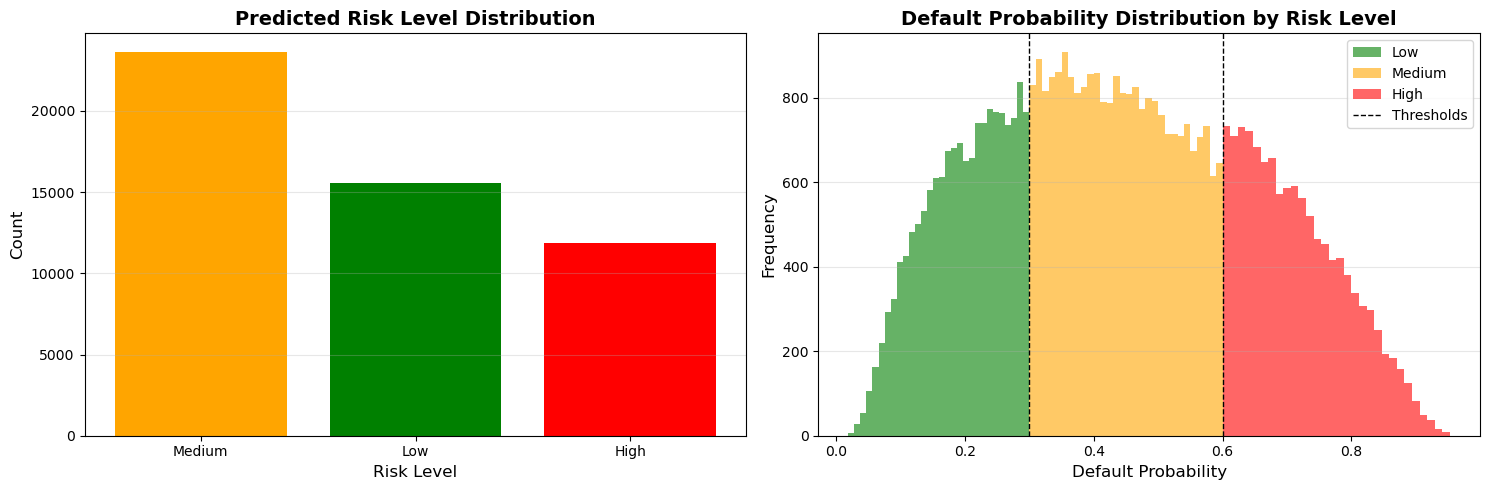

In [30]:
# Visualize risk level distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Risk level distribution
risk_counts = pd.Series(risk_levels).value_counts()
colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
risk_colors = [colors[level] for level in risk_counts.index]

axes[0].bar(risk_counts.index, risk_counts.values, color=risk_colors)
axes[0].set_title('Predicted Risk Level Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Risk Level', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Probability distribution by risk level
risk_df = pd.DataFrame({
    'Probability': default_probabilities,
    'Risk_Level': risk_levels
})

for risk_level, color in colors.items():
    data = risk_df[risk_df['Risk_Level'] == risk_level]['Probability']
    if len(data) > 0:
        axes[1].hist(data, bins=30, alpha=0.6, label=risk_level, color=color)

axes[1].axvline(x=0.3, color='black', linestyle='--', linewidth=1, label='Thresholds')
axes[1].axvline(x=0.6, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Default Probability Distribution by Risk Level', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Default Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# Analyze actual default rate by predicted risk level
risk_analysis = pd.DataFrame({
    'Actual_Default': y_test,
    'Predicted_Risk': risk_levels,
    'Default_Probability': default_probabilities
})

print("Actual Default Rate by Predicted Risk Level:")
print("="*50)
default_by_risk = risk_analysis.groupby('Predicted_Risk')['Actual_Default'].agg([
    ('Count', 'count'),
    ('Defaults', 'sum'),
    ('Default_Rate', 'mean')
])
default_by_risk['Default_Rate'] = default_by_risk['Default_Rate'] * 100
print(default_by_risk)

print("\nAverage Default Probability by Predicted Risk Level:")
print(risk_analysis.groupby('Predicted_Risk')['Default_Probability'].mean())

Actual Default Rate by Predicted Risk Level:
                Count  Defaults  Default_Rate
Predicted_Risk                               
High            11891      3238     27.230679
Low             15576       505      3.242167
Medium          23603      2188      9.270008

Average Default Probability by Predicted Risk Level:
Predicted_Risk
High      0.715512
Low       0.196758
Medium    0.443109
Name: Default_Probability, dtype: float64


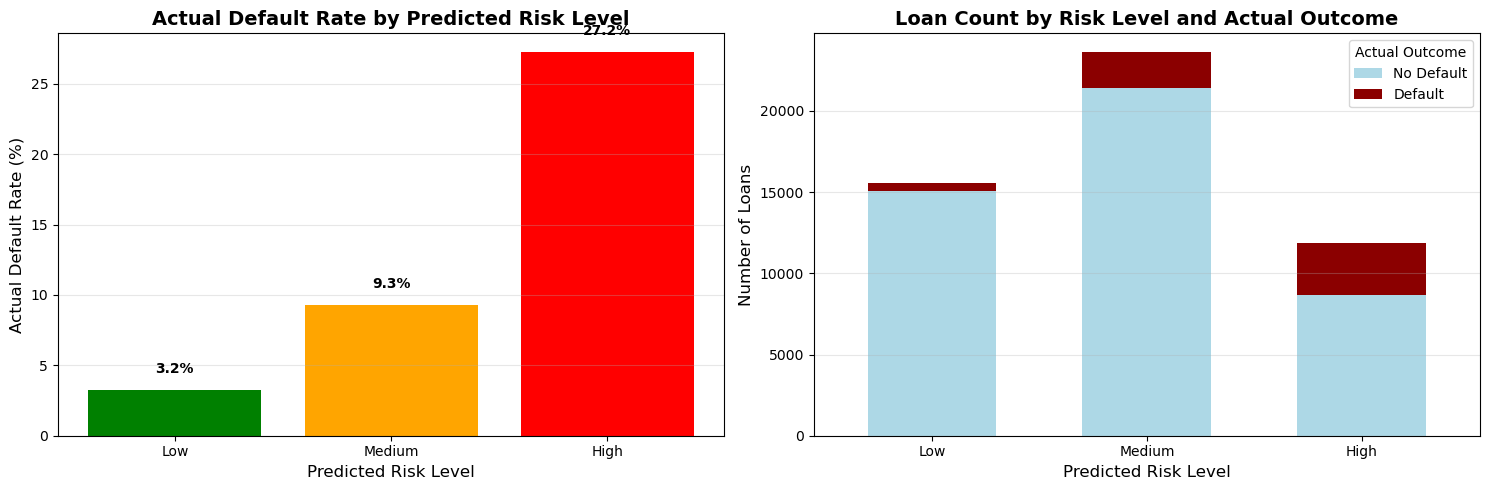

In [32]:
# Visualize model performance by risk level
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Default rate by risk level
default_rates = risk_analysis.groupby('Predicted_Risk')['Actual_Default'].mean() * 100
default_rates = default_rates.reindex(['Low', 'Medium', 'High'])
colors_ordered = ['green', 'orange', 'red']

axes[0].bar(default_rates.index, default_rates.values, color=colors_ordered)
axes[0].set_title('Actual Default Rate by Predicted Risk Level', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Risk Level', fontsize=12)
axes[0].set_ylabel('Actual Default Rate (%)', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(default_rates.values):
    axes[0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Count of loans by risk level and actual default
risk_default_counts = risk_analysis.groupby(['Predicted_Risk', 'Actual_Default']).size().unstack(fill_value=0)
risk_default_counts = risk_default_counts.reindex(['Low', 'Medium', 'High'])

risk_default_counts.plot(kind='bar', stacked=True, ax=axes[1], 
                        color=['lightblue', 'darkred'], width=0.6)
axes[1].set_title('Loan Count by Risk Level and Actual Outcome', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Risk Level', fontsize=12)
axes[1].set_ylabel('Number of Loans', fontsize=12)
axes[1].legend(['No Default', 'Default'], title='Actual Outcome')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

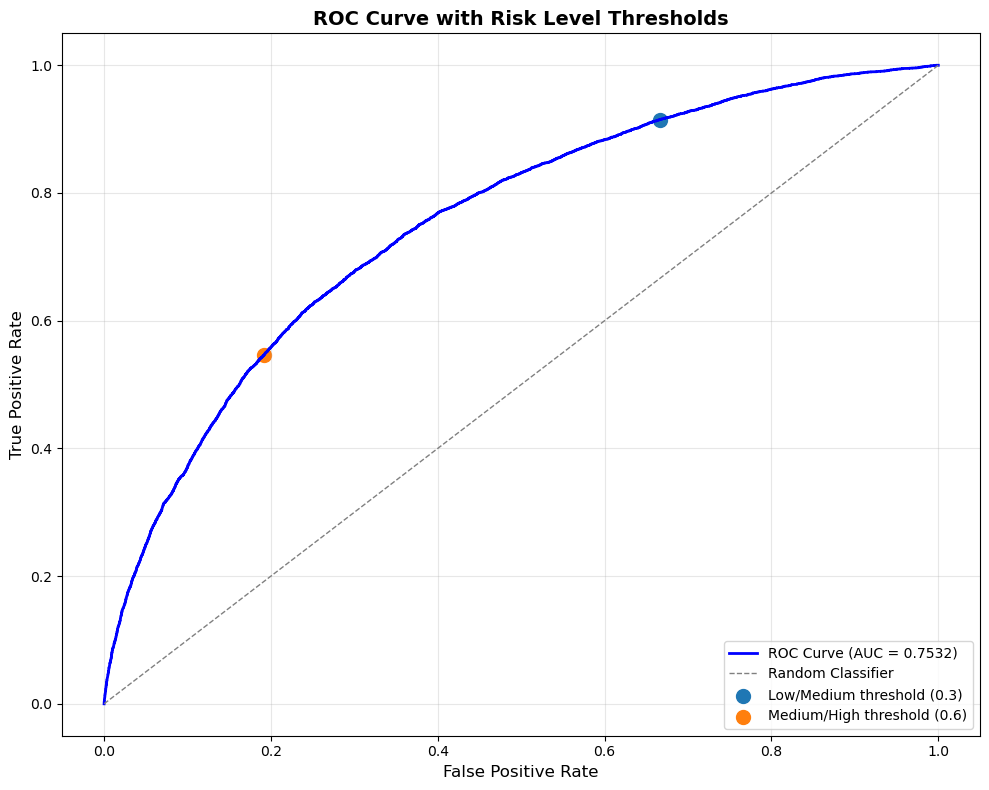

In [33]:
# Plot ROC curve with risk level thresholds
fpr, tpr, thresholds = roc_curve(y_test, default_probabilities)
roc_auc = roc_auc_score(y_test, default_probabilities)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')

# Mark the thresholds on ROC curve
for threshold, label in [(0.3, 'Low/Medium'), (0.6, 'Medium/High')]:
    idx = np.argmin(np.abs(thresholds - threshold))
    plt.scatter(fpr[idx], tpr[idx], s=100, label=f'{label} threshold ({threshold})')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve with Risk Level Thresholds', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# Save the model
joblib.dump(pipeline, 'loan_default_model.pkl')
print("Model saved as 'loan_default_model.pkl'")

Model saved as 'loan_default_model.pkl'


In [35]:
# Create comprehensive results dataframe
results_df = pd.DataFrame({
    'Actual_Default': y_test,
    'Predicted_Default': y_pred,
    'Default_Probability': default_probabilities,
    'Risk_Level': risk_levels
})

# Reset index
results_df = results_df.reset_index(drop=True)

# Save to CSV
results_df.to_csv('loan_default_predictions_with_risk.csv', index=False)
print("Predictions saved as 'loan_default_predictions_with_risk.csv'")

print(f"\nFirst 10 predictions:")
print(results_df.head(10))

Predictions saved as 'loan_default_predictions_with_risk.csv'

First 10 predictions:
   Actual_Default  Predicted_Default  Default_Probability Risk_Level
0               0                  0             0.186358        Low
1               0                  0             0.140203        Low
2               0                  0             0.378181     Medium
3               0                  1             0.569233     Medium
4               0                  0             0.407138     Medium
5               0                  0             0.068914        Low
6               0                  1             0.804479       High
7               0                  0             0.368180     Medium
8               1                  1             0.795809       High
9               0                  1             0.593022     Medium


In [36]:
# Example: Making a prediction for a new loan application
print("\n" + "="*60)
print("EXAMPLE: Predicting Risk Level for a New Loan Application")
print("="*60)

# Create a sample application (using first row from test set as example)
sample_application = X_test.iloc[[0]]

# Make prediction
default_pred = pipeline.predict(sample_application)[0]
default_prob = pipeline.predict_proba(sample_application)[0, 1]
risk_level = probability_to_risk_level(default_prob)

print(f"\nDefault Prediction: {'Yes' if default_pred == 1 else 'No'}")
print(f"Default Probability: {default_prob:.2%}")
print(f"Risk Level: {risk_level}")

print(f"\nActual Default: {'Yes' if y_test.iloc[0] == 1 else 'No'}")

# Show recommendation based on risk level
print(f"\nRecommendation:")
if risk_level == 'Low':
    print("✓ Approve with standard terms")
elif risk_level == 'Medium':
    print("⚠ Review required - consider higher interest rate or collateral")
else:
    print("✗ High risk - recommend rejection or substantial risk mitigation")


EXAMPLE: Predicting Risk Level for a New Loan Application

Default Prediction: No
Default Probability: 18.64%
Risk Level: Low

Actual Default: No

Recommendation:
✓ Approve with standard terms
